# DNN: analyse data with Keras 

## Structure of the report:

**0. Abstract (Conclusions are required to complete it, while the abstract introduction is ready)**

**1. Introduction**: what are the goals of our study, which tools we use (DNN), how we test performances (quick explanation of training and test set), how we plan to improve the performances (data augmentation, 4-Fold CV)

**2. Methods**: how training data are generated (1st and/or 2nd nonlinear functions), how training data is augmented (eventually with code snippets), definition of functions and parameters used in the CV procedure, (??rescaling function implied??)

**3. Results**: Plot of accuracies+classification for the starting DNN, accuracies varying the number (and the type) of training samples, best model of DNN after CV and plot results w.r.t. starting DNN

**4. Conclusions**: how augmenting data affects the performances, whether the CV procedure is worth to be implemented or it requires too much effort for a small gain in performances, role of each hyperparameters in the overall result, (??performaces w.r.t. rescaling??), dependence on type of function, **outlook** to further improve our model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# DNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Input
from keras import optimizers
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.optimizers as opt
from keras.constraints import maxnorm
# plot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
# plt.reParams['font.size'] = 14
import seaborn as sns

%run nonlinear_function.py

# training data
perc_train = 0.8

# data augmentation
augment_data = True
aug_amount = 3200


# save training data (loss, accuracy) in a csv file
save_csv = False

In [2]:
# Definition of useful functions

def Rescale(x, scale=50, normalize=False):
    if normalize:
        return (x-x.mean())/np.sqrt(x.var())
    elif (scale != 0):
        return x/scale
    
    return x

## Preprocessing

#### Visualization of 2D input data

L = 2

[-31.60811883 -29.54397214] 0.0
[6.77250291 9.5544703 ] 1.0
[46.45145197 15.31770969] 0.0
[24.89066375 15.35698709] 0.0
[24.77148093 46.13067361] 0.0
[-49.16117021 -39.35556233] 0.0
[-20.12962862  15.64111831] 0.0
[30.98125525 37.21759137] 0.0
[46.46475974 22.36853469] 0.0
[14.24753279 21.74536208] 1.0

data: 4000


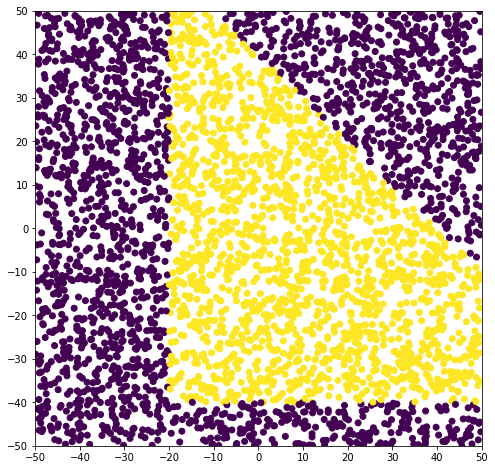

In [3]:
# Keras works with numpy arrays: just use them from the start
TYPE = 1
x = np.loadtxt(filename("data", TYPE), delimiter=' ')
y = np.loadtxt(filename("labels", TYPE), delimiter=' ')
N = len(x)

# dim of a sample
L = len(x[0])
print('L =', L)

print('')
for i in range(10):
    print(x[i], y[i])

print(f'\ndata: {N}')


# plot data with colormap
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x[:,0], x[:,1], c=y)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

#### Splitting data into training and test data

In [4]:
N_train = int(perc_train * N)

x_train, y_train = x[0:N_train], y[0:N_train]
x_valid, y_valid = x[N_train:], y[N_train:]
print('Train:', len(x_train), '\t Validation:', len(x_valid))

Train: 3200 	 Validation: 800


#### Rescale input data

In [5]:
x_train = Rescale(x_train, scale=50, normalize=False)
x_valid = Rescale(x_valid, scale=50, normalize=False)


#POINT 3 of assignment, have to try another rescaling of data

#### Data augmentation
Obviously, only the training data are augmented, while the validation set remains unchanged.

In [6]:
if augment_data:

    # generate random shifts for the selected training data
    theta = np.random.rand(aug_amount)*(2*np.pi) # random directions of shifts
    mask = np.random.choice(x_train.shape[0], aug_amount, replace=True)
    shift = np.random.normal(loc=0.1, scale=0.001, size=aug_amount)

    # augmented data are shifted w.r.t. the original data
    # and have the same label
    x_aug = x_train[mask] +  np.vstack((shift*np.cos(theta),shift* np.sin(theta))).T
    y_aug = y_train[mask]

    # training data are increased
    x_train = np.vstack((x_train, x_aug))
    y_train = np.hstack((y_train, y_aug))

    print('training data:', x_train.shape[0])


training data: 6400


In [7]:
# Switching to one-hot encoding
num_classes = 2
y_train =tf.keras.utils.to_categorical(y_train, num_classes)
y_valid =tf.keras.utils.to_categorical(y_valid, num_classes)


## Base model with Keras

In [8]:
# reproducibility
np.random.seed(12345) # maybe not useful (Keras has is own initialization..)

# sequential model
CASE=1

if CASE==1:
    model=Sequential()
    model.add(Input(shape=(L,)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='sigmoid'))
    nepoch=400
    batch_size=50

if CASE==2:
    model=Sequential()
    model.add(Input(shape=(L,)))
    model.add(Dense(3, activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='sigmoid'))
    nepoch=400
    batch_size=50
    
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 42        
                                                                 
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________
None


### Optimization method and cost function

In [9]:
model.compile(loss='binary_crossentropy', 
              #optimizer='RMSprop',
              optimizer='adam', 
              metrics=['accuracy'])

### Training

In [10]:
fit = model.fit(x_train, y_train, 
                epochs = nepoch, batch_size=batch_size, 
                validation_data=(x_valid, y_valid), 
                verbose=0)

In [11]:
print('Training error: %.4f' %fit.history['loss'][-1])
print('Validation error: %.4f' %fit.history['val_loss'][-1])


Training error: 0.1118
Validation error: 0.0485


### Saving history of training in a .csv file

In [12]:
if save_csv: 
    import csv

    training_data = np.column_stack((fit.history['accuracy'], fit.history['val_accuracy'], fit.history['loss'], fit.history['val_loss']))

    if augment_data: 
        filename = 'TrainingHistory/training_Augmented_'+str(aug_amount)+'.csv'
    else:
        filename = 'TrainingHistory/training_'+str(N)+'.csv'
    header = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    with open(filename, 'w', encoding='UTF8', newline='') as f:
        writer = csv.writer(f)

        writer.writerow(header)
        writer.writerows(training_data)


### History plots of train and test performances

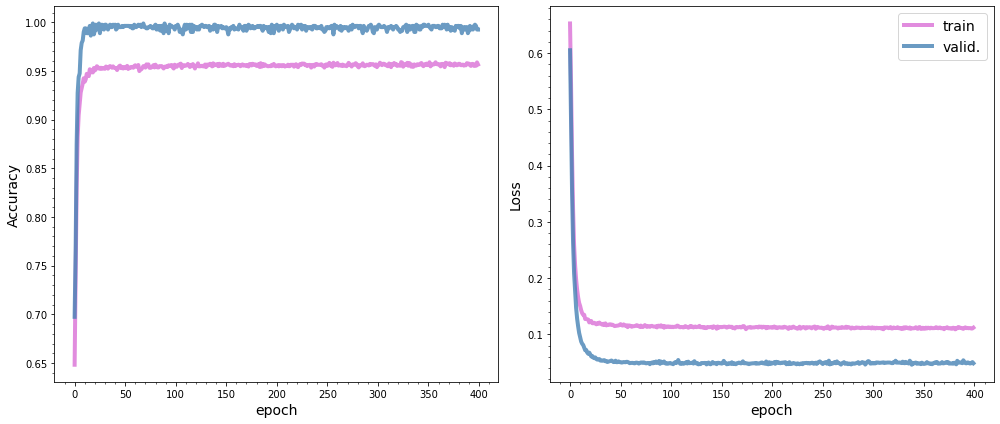

In [13]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(fit.history['accuracy'], linewidth=4, color='orchid', alpha=0.8)
ax.plot(fit.history['val_accuracy'], linewidth=4, color='steelblue', alpha=0.8)

ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.minorticks_on()

ax=AX[1]
ax.plot(fit.history['loss'],label="train", linewidth=4, color='orchid', alpha=0.8)
ax.plot(fit.history['val_loss'],label="valid.", linewidth=4, color='steelblue', alpha=0.8)

ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.minorticks_on()

ax.legend(loc="upper right", fontsize=14)

fig.tight_layout()


In [14]:
dX = 1
X1 = np.arange(-50,50+dX, dX)
LG = len(X1)
grid = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid))
print(grid[-1])

# Rescale grid with the same rescaling function
grid_r = Rescale(grid, scale=50, normalize=False)

# predict labels on the grid
pred = model.predict(grid_r)

101 10201
[50. 50.]


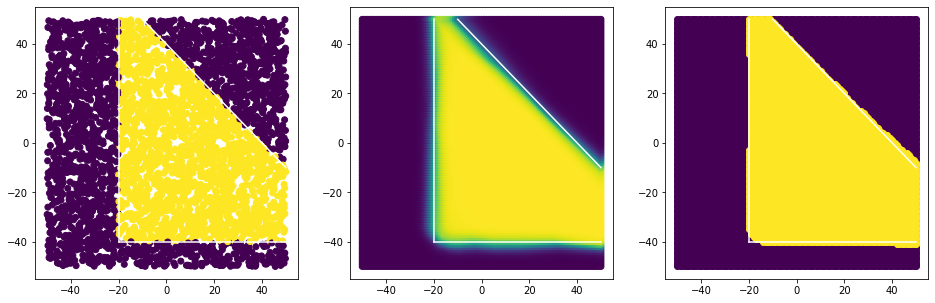

In [15]:
def boundaries():    
    ax.plot((-20,-20),(-40,50),c="w")
    ax.plot((-20,50),(-40,-40),c="w")
    ax.plot((-10,50),(50,-10),c="w")
    
fig,AX = plt.subplots(1,3,figsize=(16,5.))

ax=AX[0]
ax.scatter(x[:,0],x[:,1], c=y)
boundaries()

ax=AX[1]
ax.scatter(grid[:,0],grid[:,1],c=pred[:,1])
boundaries()

ax=AX[2]
W1=np.where(pred[:,1]>0.5)[0] 
ax.scatter(grid[:,0],grid[:,1],c="#440154")
ax.scatter(grid[W1,0],grid[W1,1],c="#fde725")
boundaries()

plt.show()

### History plots for different training sets (different N)

In [16]:
folder_name = 'TrainingHistory'
file_names = ['training_2000.csv', 'training_4000.csv', 'training_6000.csv', 'training_Augmented_3200.csv']
file_paths = [folder_name+"/"+name for name in file_names]

df_dic={'N='+path[len(folder_name)+10:-4]: pd.read_csv(path) for path in file_paths[:-1]}
df_dic[f'Data augmentation']= pd.read_csv(file_paths[-1])
    
print('Dataframes available: ', [i for i in df_dic.keys()])

Dataframes available:  ['N=2000', 'N=4000', 'N=6000', 'Data augmentation']


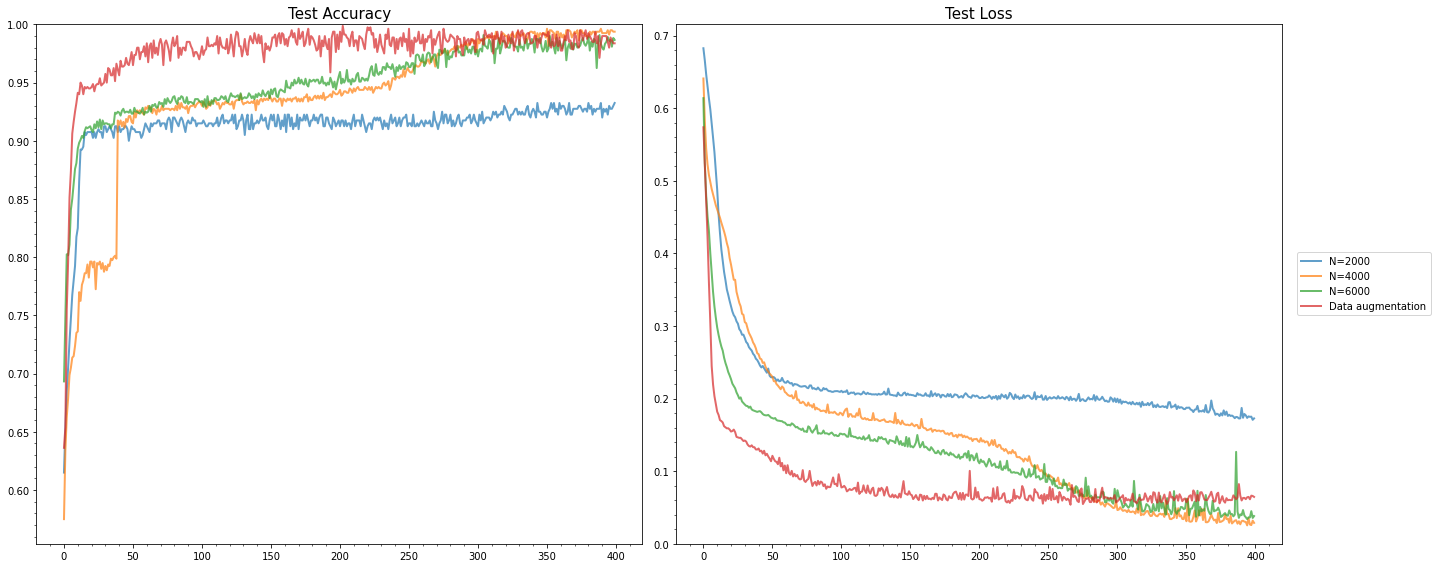

In [17]:
fig, AX = plt.subplots(1,2,figsize=(18,8))

for key in df_dic:
    AX[0].plot(df_dic[key]['val_accuracy'], label=key, linewidth=2, alpha=0.7)
    AX[1].plot(df_dic[key]['val_loss'], label=key, linewidth=2, alpha=0.7)

AX[0].minorticks_on()
AX[0].set_title("Test Accuracy", fontsize=15)
AX[0].set_ylim(top=1)
# AX[0].legend(loc="lower right", fontsize=10)

AX[1].minorticks_on()
AX[1].set_title("Test Loss", fontsize=15)
AX[1].set_ylim(bottom=0)
# AX[1].legend(loc="upper right", fontsize=10)

axLines, axLabels = AX[0].get_legend_handles_labels()
 
fig.legend(axLines, axLabels, 
    loc='center left', bbox_to_anchor=(1, 0.5)
    )

fig.tight_layout()
plt.show()


## Improving the base model with Grid Search


### General model definition

In [18]:
# compile a specified model with a particular optimizer
# useful for GridSearchCV
def compile_model(optimizer, activation, dropout, layer_size, weight_constraint):

    # create the model
    model = Sequential()

    # add architecture specs
    # first layer: SPECIFIED EXPLICITLY
    model.add(Input(shape=(L,)))

    # hidden layers
    for lyr_sz in layer_size:
        model.add(Dense(lyr_sz, activation=activation, kernel_constraint=maxnorm(weight_constraint)))

    # dropout rate
    model.add(Dropout(dropout))

    # output layer
    model.add(Dense(num_classes, activation='sigmoid'))

    
    # compile the model
    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])


    return model                



# call Keras scikit wrapper
model_gridsearch = KerasClassifier(build_fn=compile_model, 
                        epochs=1, 
                        batch_size=batch_size, 
                        verbose=0)


<ipython-input-18-7b6e4350e7af>:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch = KerasClassifier(build_fn=compile_model,


### Perform Grid Search CV
For the moment only few parameters are uncommented, future runs will consider all the choices

In [19]:
# list of allowed optional arguments for the optimizer
nesterov = opt.SGD(nesterov=True)
#optimizer = ['Adam', 'RMSprop', 'SGD', nesterov]
optimizer= ['Adam', 'RMSprop']
activation = ['sigmoid', 'relu']
#activation = ['sigmoid', 'relu', 'elu', 'tanh']
dropout = [0.05, 0.2, 0.4]
layer_size = [(50,50,), (5,5,5,5,)]
weight_constraint = [1, 2, 3]

# define parameter dictionary
param_grid = {'optimizer': optimizer,
              'activation': activation,
              'dropout': dropout,
              'layer_size': layer_size,
               'weight_constraint': weight_constraint
              }

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=1, cv=4)
grid_result = grid.fit(x_train,y_train)

### Grid Search CV results

In [20]:
# summarize results

results_df = pd.DataFrame(grid.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:,["param_"+k for k in param_grid.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
print(grid_result.best_params_)

print("\nScore with best parameters:")
print(grid_result.best_score_)

,param_optimizer,param_activation,param_dropout,param_layer_size,param_weight_constraint,mean_test_score,rank_test_score
0,RMSprop,relu,0.05,"(50, 50)",3,0.766719,1
1,RMSprop,relu,0.2,"(50, 50)",1,0.765781,2
2,Adam,relu,0.05,"(50, 50)",3,0.764844,3
3,RMSprop,relu,0.05,"(50, 50)",2,0.764375,4
4,RMSprop,relu,0.4,"(50, 50)",1,0.762344,5
...,...,...,...,...,...,...,...
67,RMSprop,sigmoid,0.2,"(5, 5, 5, 5)",1,0.500625,67
68,Adam,sigmoid,0.4,"(5, 5, 5, 5)",3,0.499375,69
69,Adam,sigmoid,0.05,"(5, 5, 5, 5)",1,0.499375,69
70,RMSprop,sigmoid,0.05,"(5, 5, 5, 5)",1,0.487812,71




Best parameters set found:
{'activation': 'relu', 'dropout': 0.05, 'layer_size': (50, 50), 'optimizer': 'RMSprop', 'weight_constraint': 3}

Score with best parameters:
0.7667187452316284


**Let's try to find meaningful data into CV folds...**

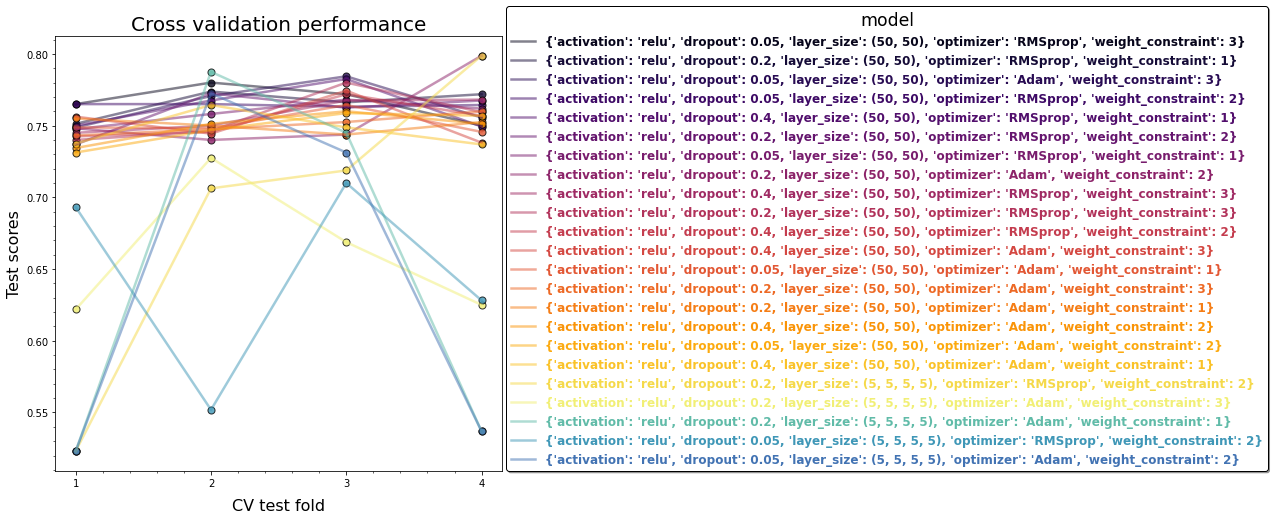

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Cross validation performance'}, xlabel='CV test fold', ylabel='Test scores'>)

In [21]:
def cv_plot(cv_results, figsize, leg_size, folds):
    results_df = pd.DataFrame(cv_results).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
    x_axis=np.arange(1, folds+1)
    model_scores = results_df.filter(regex=r"split\d*_test_score")
    color_list= sns.color_palette("inferno", 20).as_hex() + ['#60bba8', '#3f97b7', '#4273b3']
    
    # plot 30 examples of dependency between cv fold and AUC scores
    fig, ax = plt.subplots(figsize=figsize)
    for item, color in zip(range(0,24), color_list):
        ax.plot(x_axis, model_scores.iloc[item,:], alpha=0.5, color = color, label=results_df['params'][item], linewidth=2.5)
        ax.scatter(x_axis, model_scores.iloc[item,:], alpha=0.8, color = color, s=50, edgecolor='black')
    
    ax.set_xlabel("CV test fold", size=16, labelpad=10)
    ax.set_ylabel("Test scores", size=16)
    ax.set_xticks(ticks=x_axis)
    ax.legend(shadow=True, framealpha=1, facecolor='white', edgecolor='black', title='model', title_fontsize='xx-large', prop={'weight':'bold','size':leg_size}, loc=(1.01,0), labelcolor='linecolor', markerscale=2)
    ax.minorticks_on()
    ax.set_title('Cross validation performance', fontsize=20)

    plt.show()
    return fig, ax

cv_plot(cv_results=grid.cv_results_, figsize=(8,8), leg_size=12, folds=4)



### Fine Tuning of optimizer parameters (learning rate, momentum)
We set the best optimizer form the previous CV and we perform another CV to fine tune the optimizer parameters

In [22]:
# SUPPOSING RMSprop IS THE BEST OPTIMIZER
# MAYBE WILL NEED CORRECTIONS IN THE FUTURE
def FineTune_opt(best_params=grid_result.best_params_, learn_rate=0.001, momentum=0.0):
    
	# define optimizer
    optimizer = opt.RMSprop(learning_rate = learn_rate,
                            rho = 0.9,
                            momentum = momentum,
                            epsilon = 1e-07,
                            centered = False,
                            name = "RMSprop")
    
    # compile model with the general function
    # DNN architecture parameters are fixed to the best value
    model = compile_model(optimizer = optimizer,
                          activation = best_params['activation'],
                          dropout = best_params['dropout'],
                          layer_size = best_params['layer_size'],
                          weight_constraint = best_params['weight_constraint']
                          )

    return model                


# call Keras scikit wrapper
model_gridsearch_FineTune_opt = KerasClassifier(build_fn=FineTune_opt,
                                                epochs=1,
                                                batch_size=batch_size,
                                                verbose=0)

<ipython-input-22-509b23b50b81>:26: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_gridsearch_FineTune_opt = KerasClassifier(build_fn=FineTune_opt,


#### Perform Fine Tuning of optimizer via Grid Search CV

In [23]:
# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]


# define parameter dictionary
param_grid_FineTune_opt = {
                           'learn_rate': learn_rate,
                           'momentum': momentum
                           }
#'best_params':[grid_result.best_params_],
# call scikit grid search module
grid_FineTune_opt = GridSearchCV(estimator=model_gridsearch_FineTune_opt,
                                 param_grid=param_grid_FineTune_opt,
                                 n_jobs=1,
                                 cv=4)
grid_result_FineTune_opt = grid_FineTune_opt.fit(x_train,y_train)

#### Fine Tuning results

In [24]:
means = grid_result_FineTune_opt.cv_results_['mean_test_score']
params = grid_result_FineTune_opt.cv_results_['params']


for mean, param in zip(means, params):
    print("%f with: %r" % (mean, param))


# summarize results
print("\n Best Score with ", grid_result.best_params_['optimizer'], " : %f using %s" % (grid_result_FineTune_opt.best_score_, grid_result_FineTune_opt.best_params_))

0.769063 with: {'learn_rate': 0.001, 'momentum': 0.0}
0.784531 with: {'learn_rate': 0.001, 'momentum': 0.2}
0.828750 with: {'learn_rate': 0.001, 'momentum': 0.4}
0.879844 with: {'learn_rate': 0.001, 'momentum': 0.6}
0.916562 with: {'learn_rate': 0.001, 'momentum': 0.8}
0.924062 with: {'learn_rate': 0.001, 'momentum': 0.9}
0.917344 with: {'learn_rate': 0.01, 'momentum': 0.0}
0.917969 with: {'learn_rate': 0.01, 'momentum': 0.2}
0.938750 with: {'learn_rate': 0.01, 'momentum': 0.4}
0.911563 with: {'learn_rate': 0.01, 'momentum': 0.6}
0.918750 with: {'learn_rate': 0.01, 'momentum': 0.8}
0.904219 with: {'learn_rate': 0.01, 'momentum': 0.9}
0.917031 with: {'learn_rate': 0.1, 'momentum': 0.0}
0.887500 with: {'learn_rate': 0.1, 'momentum': 0.2}
0.907969 with: {'learn_rate': 0.1, 'momentum': 0.4}
0.839219 with: {'learn_rate': 0.1, 'momentum': 0.6}
0.889687 with: {'learn_rate': 0.1, 'momentum': 0.8}
0.858281 with: {'learn_rate': 0.1, 'momentum': 0.9}
0.913281 with: {'learn_rate': 0.2, 'momentum':

In [25]:
# summarize results
results_df = pd.DataFrame(grid_FineTune_opt.cv_results_).sort_values(by=["rank_test_score"], ascending=True, ignore_index=True)
display(results_df.loc[:,["param_"+k for k in param_grid_FineTune_opt.keys()]+["mean_test_score","rank_test_score"]])

print("\n\nBest parameters set found:")
print(grid_result_FineTune_opt.best_params_)

print("\nScore with best parameters:")
print(grid_result_FineTune_opt.best_score_)

,param_learn_rate,param_momentum,mean_test_score,rank_test_score
0,0.01,0.4,0.938750,1
1,0.001,0.9,0.924062,2
2,0.01,0.8,0.918750,3
3,0.01,0.2,0.917969,4
4,0.01,0.0,0.917344,5
5,0.1,0.0,0.917031,6
6,0.001,0.8,0.916562,7
7,0.2,0.0,0.913281,8
8,0.01,0.6,0.911563,9
9,0.1,0.4,0.907969,10




Best parameters set found:
{'learn_rate': 0.01, 'momentum': 0.4}

Score with best parameters:
0.9387499988079071


In [26]:
# best model until now
best_model = FineTune_opt(best_params=grid_result.best_params_,
                          learn_rate=grid_result_FineTune_opt.best_params_['learn_rate'],
                          momentum=grid_result_FineTune_opt.best_params_['momentum']
                          )

print(best_model.summary())

Model: "sequential_411"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1521 (Dense)          (None, 50)                150       
                                                                 
 dense_1522 (Dense)          (None, 50)                2550      
                                                                 
 dropout_411 (Dropout)       (None, 50)                0         
                                                                 
 dense_1523 (Dense)          (None, 2)                 102       
                                                                 
Total params: 2,802
Trainable params: 2,802
Non-trainable params: 0
_________________________________________________________________
None


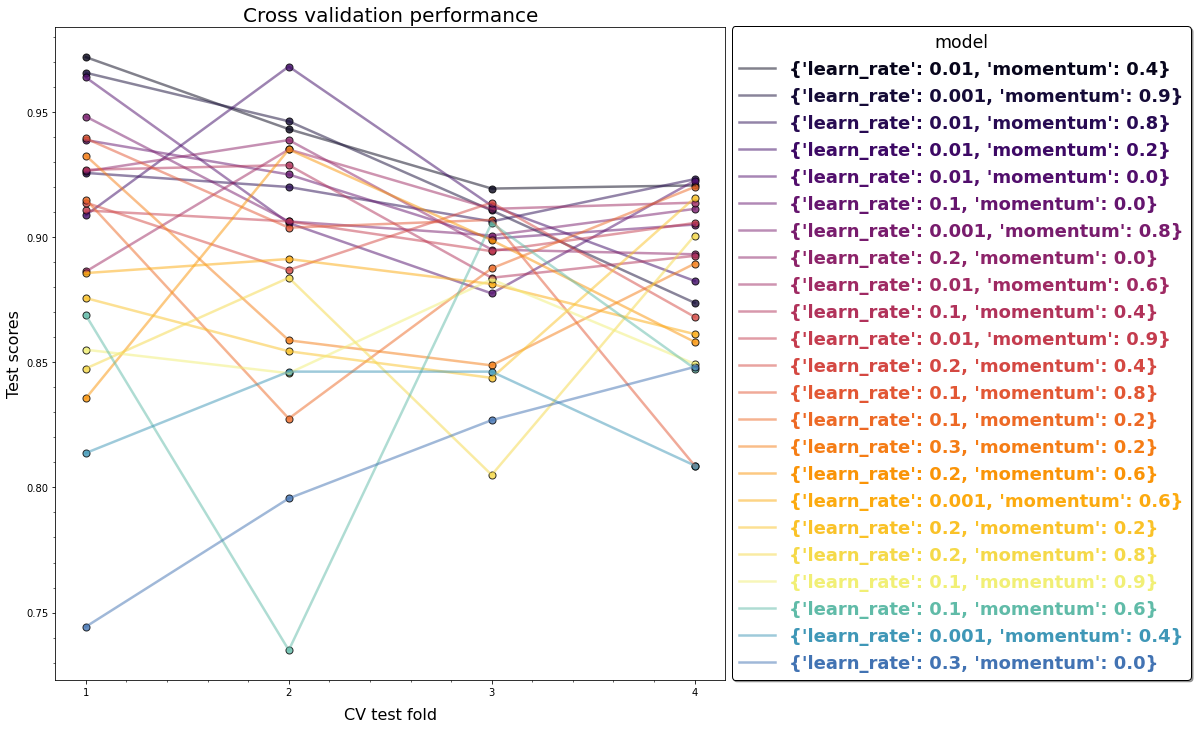

(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:title={'center':'Cross validation performance'}, xlabel='CV test fold', ylabel='Test scores'>)

In [27]:
cv_plot(cv_results=grid_result_FineTune_opt.cv_results_, figsize=(12,12), leg_size=18, folds=4)

## TODO??: study the correlation between best parameters and training sets
## Create a function that encapsulate the following steps:

1. Generate a training set given its attributes (i.e., N, augment_data)
2. Define a grid of values and perform a CV using the function `compile_model`)
3. Eventually, compute the fine tuning parameters for the best optimizer found by CV
4. Study the correlation between best parameters and the training set

## Study of another non-linear function

WARNING!! Duplication from now on

L = 2

data: 4000


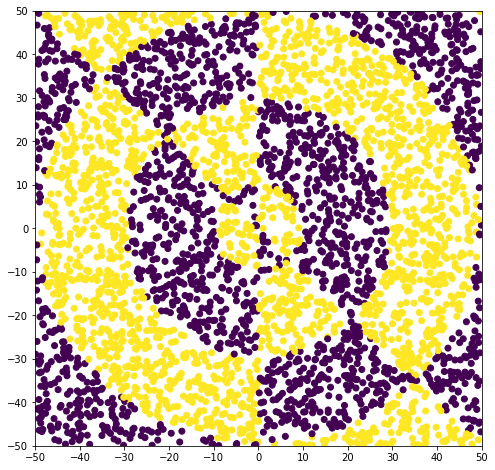

In [28]:
TYPE = 2
x2 = np.loadtxt(filename("data", TYPE), delimiter=' ')
y2 = np.loadtxt(filename("labels", TYPE), delimiter=' ')
N_2 = len(x2)

# dim of a sample
L_2 = len(x2[0])
print('L =', L_2)

print(f'\ndata: {N_2}')


# plot data with colormap
fig,ax = plt.subplots(figsize=(8,8))
ax.scatter(x2[:,0], x2[:,1], c=y2)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

In [29]:
N2_train = int(perc_train * N_2)   #maintain the same perc = 0.8

x2_train, y2_train = x2[0:N2_train], y2[0:N2_train]
x2_valid, y2_valid = x2[N2_train:], y2[N2_train:]
print('Train:', len(x2_train), '\t Validation:', len(x2_valid))


# Rescaling data using the same rescaling function
x2_train = Rescale(x2_train, scale=50, normalize=False)
x2_valid = Rescale(x2_valid, scale=50, normalize=False)


# Switching to one-hot encoding  num_classes = 2
y2_train =tf.keras.utils.to_categorical(y2_train, num_classes)
y2_valid =tf.keras.utils.to_categorical(y2_valid, num_classes)

Train: 3200 	 Validation: 800


In [37]:
# sequential model
CASE=1

if CASE==1:
    model=Sequential()
    model.add(Input(shape=(L_2,)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='sigmoid'))
    nepoch=400
    batch_size=50

if CASE==2:
    model=Sequential()
    model.add(Input(shape=(L_2,)))
    model.add(Dense(3, activation='sigmoid'))
    model.add(Dense(2, activation='sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='sigmoid'))
    nepoch=400
    batch_size=50
    
print(model.summary())

Model: "sequential_413"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1528 (Dense)          (None, 3)                 9         
                                                                 
 dense_1529 (Dense)          (None, 2)                 8         
                                                                 
 dropout_413 (Dropout)       (None, 2)                 0         
                                                                 
 dense_1530 (Dense)          (None, 2)                 6         
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
model.compile(loss='binary_crossentropy', 
              #optimizer='RMSprop',
              optimizer='adam', 
              metrics=['accuracy'])

In [39]:
fit_2 = model.fit(x2_train, y2_train, 
                epochs = nepoch, batch_size=batch_size, 
                validation_data=(x2_valid, y2_valid), 
                verbose=0)

In [40]:
print('Training error: %.4f' %fit_2.history['loss'][-1])
print('Validation error: %.4f' %fit_2.history['val_loss'][-1])

Training error: 0.6838
Validation error: 0.6940


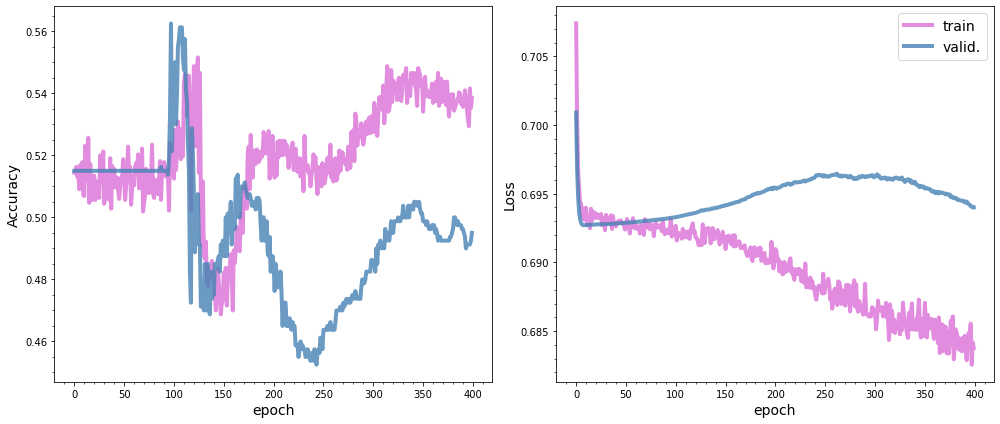

In [41]:
fig,AX=plt.subplots(1,2,figsize=(14,6.))

ax=AX[0]
ax.plot(fit_2.history['accuracy'], linewidth=4, color='orchid', alpha=0.8)
ax.plot(fit_2.history['val_accuracy'], linewidth=4, color='steelblue', alpha=0.8)

ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel("Accuracy", fontsize=14)
ax.minorticks_on()

ax=AX[1]
ax.plot(fit_2.history['loss'],label="train", linewidth=4, color='orchid', alpha=0.8)
ax.plot(fit_2.history['val_loss'],label="valid.", linewidth=4, color='steelblue', alpha=0.8)

ax.set_xlabel('epoch', fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.minorticks_on()

ax.legend(loc="upper right", fontsize=14)

fig.tight_layout()

In [42]:
grid2 = np.zeros((LG*LG,2))
k=0
for i in range(LG):
    for j in range(LG):
        grid2[k,:]=(X1[j],X1[i])
        k=k+1
print(len(X1),len(grid2))
print(grid2[-1])



# RESCALE maintaining the same grid [-50,50]x[-50,50]
grid2_r = Rescale(grid2, scale=50, normalize=False)

pred_2 = model.predict(grid2_r)


101 10201
[50. 50.]


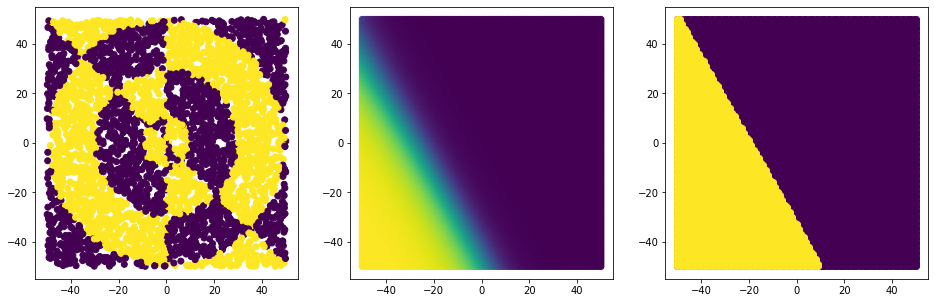

In [43]:
fig,AX = plt.subplots(1,3,figsize=(16,5.))

ax=AX[0]
ax.scatter(x2[:,0],x2[:,1], c=y2)


ax=AX[1]
ax.scatter(grid2[:,0],grid2[:,1],c=pred_2[:,1])


ax=AX[2]
W1=np.where(pred_2[:,1]>0.5)[0] 
ax.scatter(grid2[:,0],grid2[:,1],c="#440154")
ax.scatter(grid2[W1,0],grid2[W1,1],c="#fde725")


plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68aafe1b-040f-4657-bf91-52c6a793f99c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>